# Task 1

**Description**

* Implement SGD
* Implement Adam

Although task requires to define any function $R^2 \rightarrow R$. Implementing SGD really requires that gradient computation can be done on some portion of the data available, this makes optimizing analytical functions cumbersome, so instead we will use toy XOR problem and make classification

In [1]:
import numpy as np
import abc
from matplotlib import pyplot as plt

**Fix random seed for reproducibility**

In [2]:
np.random.seed(0)

**Data generation**

In [3]:
def generate_data_xor(size: int = 10_000, spread: float = 10.0) -> (np.array, np.array):
    assert(size >= 4)
    blob_size = int(size / 4)

    positive_labels = np.ones((1, blob_size)).ravel()
    negative_labels = -positive_labels

    up = np.stack([np.array([0, spread]) for _ in range(blob_size)], axis=0)
    right = np.stack([np.array([spread, 0]) for _ in range(blob_size)], axis=0)
    left = np.stack([np.array([-spread, 0]) for _ in range(blob_size)], axis=0)
    down = np.stack([np.array([0, -spread]) for _ in range(blob_size)], axis=0)

    data = np.concatenate((
        np.c_[ np.random.rand(blob_size, 2) + up + left, positive_labels ], 
        np.c_[ np.random.rand(blob_size, 2) + up + right, negative_labels ], 
        np.c_[ np.random.rand(blob_size, 2) + down + right, positive_labels ], 
        np.c_[ np.random.rand(blob_size, 2) + down + left, negative_labels ]
    ), axis=0)
    np.random.shuffle(data)
    return data[:, 0:-1], data[:, -1].astype(np.int32)

**Helper function to draw dataset**

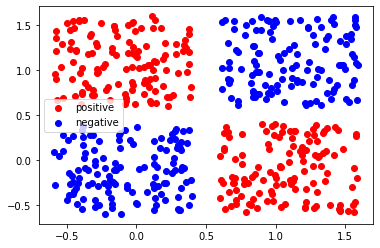

In [4]:
def plot_data(X, y):
    data = np.c_[X, y]
    positive = data[data[:, -1] == 1][:, 0:-1]
    negative = data[data[:, -1] == -1][:, 0:-1]
    
    plt.scatter(positive[:, 0], positive[:, 1], c="r", label="positive")
    plt.scatter(negative[:, 0], negative[:, 1], c="b", label="negative")
    plt.legend()
    
plot_data(*generate_data_xor(size=500, spread=0.6))

**Really verbose but understandable simple helpers and interfaces**

**Data class to hold training meta information**

In [5]:
class History:
    __slots__ = "path", "loss"
    def __init__(self, path: [np.array], loss: np.array):
        self.path = path
        self.loss = loss

**Loss function**

In [6]:
def softmax(predictions):
    single = predictions.ndim == 1
    if single:
        predictions = predictions.reshape(1, predictions.shape[0])

    # trick for computational stability
    predictions_ts = predictions - np.amax(predictions, axis=1).reshape(predictions.shape[0], 1)

    predictions_exp = np.exp(predictions_ts)
    sums = np.sum(predictions_exp, axis=1).reshape(predictions_exp.shape[0], 1)
    result = predictions_exp / sums

    if single:
        result = result.reshape(result.size)

    return result

def cross_entropy_loss(probs, target_index):
    if probs.ndim == 1:
        probs = probs.reshape(1, probs.shape[0])
        target_index = np.array([target_index])

    rows = np.arange(target_index.shape[0])
    cols = target_index

    return np.mean(-np.log(probs[rows, cols.astype(np.int32)]))

def softmax_with_cross_entropy(predictions, target_index):
    single = predictions.ndim == 1
    if single:
        predictions = predictions.reshape(1, predictions.shape[0])
        target_index = np.array([target_index])

    probs = softmax(predictions)
    loss = cross_entropy_loss(probs, target_index)

    indicator = np.zeros(probs.shape)
    indicator[np.arange(probs.shape[0]), target_index] = 1
    dprediction = (probs - indicator) / predictions.shape[0]

    if single:
        dprediction = dprediction.reshape(dprediction.size)

    return loss, dprediction

class DifferentiableFunction(abc.ABC):
    @abc.abstractmethod
    def __call__(self, x: np.array, w: np.array, batch_idx: np.array) -> (np.array, np.array):
        pass

class SoftmaxLoss(DifferentiableFunction):
    # noinspection PyMethodOverriding
    def __call__(self, x: np.array, w: np.array, batch_idx: np.array) -> (np.array, np.array):
        predictions = np.dot(x, w)
        loss, dpredictions = softmax_with_cross_entropy(predictions, batch_idx)
        dW = np.dot(dpredictions.T, x).T
        return loss, dW

**Learning rate schedulers**

In [7]:
class LearningRateScheduler(abc.ABC):
    @abc.abstractmethod
    def get(self, iteration: int = None, loss: int = None) -> float:
        pass

class ConstantLearningRate(LearningRateScheduler):
    def __init__(self, lr: float = 1e-7):
        self.lr = lr

    def get(self, iteration: int = None, loss: int = None) -> float:
        return self.lr

**Optimizers (the fun part)**

In [8]:
class Optimizer(abc.ABC):
    @abc.abstractmethod
    def step(self, parameters, gradient):
        pass

    @abc.abstractmethod
    def get_batch_size(self):
        pass

## SGD

In [9]:
class SGD(Optimizer):

    def __init__(self,
                 batch_size: int = 16,
                 lr: LearningRateScheduler = ConstantLearningRate()):
        self.batch_size = batch_size
        self.lr = lr

    def step(self, parameters, gradient):
        delta = self.lr.get() * gradient
        return delta

    def get_batch_size(self) -> int:
        return self.batch_size

## Adam

In [10]:
class Adam(Optimizer):

    def __init__(self,
                 batch_size: int = 16,
                 beta1: float = 0.9,
                 beta2: float = 0.999,
                 eps: float = 1e-7,
                 lr: LearningRateScheduler = ConstantLearningRate()):
        self.batch_size: int = batch_size
        self.beta1: float = beta1
        self.beta2: float = beta2
        self.eps: float = eps
        self.lr: LearningRateScheduler = lr
        self.cache: dict = {
            "t": -1,
            "mean": None,
            "var": None,
        }
    
    def get_batch_size(self) -> int:
        return self.batch_size

    def step(self, parameters, gradient):
        if self.cache["t"] == -1:
            self.cache = {
                "t": 0,
                "mean": np.zeros_like(parameters),
                "variance": np.zeros_like(parameters)
            }

        t = self.cache["t"] + 1
        mean = self.cache["mean"]
        variance = self.cache["variance"]

        self.cache["t"] = t
        self.cache["mean"] = self.beta1 * mean + (1 - self.beta1) * gradient
        self.cache["variance"] = self.beta2 * variance + (1 - self.beta2) * gradient ** 2
        
        v_hat = self.cache["variance"] / (1. - (self.beta2 ** t))
        m_hat = self.cache["mean"] / (1. - (self.beta1 ** t))
        
        update = self.lr.get(iteration=t) * m_hat / (np.sqrt(v_hat) + self.eps)
        return update

## Tests

In [11]:
class LinearClassificationModel:

    def __init__(self):
        self.W = None

    def init_weights(self, W):
        self.W = W

    def fit(self, X, y, optimizer: Optimizer, loss_fn: DifferentiableFunction, epochs=1, verbose=10) -> History:
        num_samples_train = X.shape[0]
        num_features = X.shape[1]
        num_classes = len(np.unique(y))

        if self.W is None:
            self.init_weights(W = 0.001 * np.random.randn(num_features, 2))

        history_loss = []
        history_parameters = []

        for epoch in range(epochs):
            shuffled_idx = np.arange(num_samples_train)
            np.random.shuffle(shuffled_idx)

            batch_size = optimizer.get_batch_size()
            sections = np.arange(batch_size, num_samples_train, batch_size)
            batches_idx = np.array_split(shuffled_idx, sections)
            
            loss_epoch = 0
            batches = 0
            for batch_idx in batches_idx:
                X_batch = X[batch_idx, :]
                y_batch = y[batch_idx]

                loss, grad = loss_fn(X_batch, self.W, y_batch)

                # modifies parameters in-place
                self.W -= optimizer.step(self.W, gradient=grad)
                
                loss_epoch += loss
                batches += 1
            
            loss_epoch = loss_epoch / batches
            history_loss.append(loss_epoch)
            history_parameters.append(self.W)
            
            if epoch % verbose == 0:
                print(f"Current epoch: \t {epoch}, \t loss: {loss_epoch}")

        return History(path=history_parameters, loss=history_loss)

    def predict(self, X):
        y_pred = np.dot(X, self.W)
        probabilities = softmax(y_pred)
        return np.argmax(probabilities, axis=-1)

**Generate data for classification task**

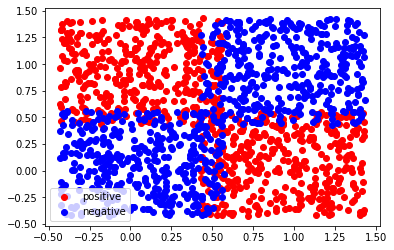

In [12]:
X, y = generate_data_xor(size=1500, spread=0.43)

plot_data(X, y)

**Training with SDG optmizer**

In [13]:
model = LinearClassificationModel()

optmizer = SGD(lr = ConstantLearningRate(0.00005))

sgd_history = model.fit(X, y, optimizer = optmizer, loss_fn = SoftmaxLoss(), epochs = 200)

Current epoch: 	 0, 	 loss: 0.692314951504052
Current epoch: 	 10, 	 loss: 0.680557912073484
Current epoch: 	 20, 	 loss: 0.6692117330757366
Current epoch: 	 30, 	 loss: 0.6582967470770115
Current epoch: 	 40, 	 loss: 0.6477300339614158
Current epoch: 	 50, 	 loss: 0.6375529040396726
Current epoch: 	 60, 	 loss: 0.6277980186059853
Current epoch: 	 70, 	 loss: 0.6183791263783222
Current epoch: 	 80, 	 loss: 0.609243436536217
Current epoch: 	 90, 	 loss: 0.6003843491321469
Current epoch: 	 100, 	 loss: 0.5919519849542982
Current epoch: 	 110, 	 loss: 0.5837575746653291
Current epoch: 	 120, 	 loss: 0.5759181129922075
Current epoch: 	 130, 	 loss: 0.5682986096344385
Current epoch: 	 140, 	 loss: 0.5608747617466027
Current epoch: 	 150, 	 loss: 0.5536982793671308
Current epoch: 	 160, 	 loss: 0.5469004264998016
Current epoch: 	 170, 	 loss: 0.5402100423193382
Current epoch: 	 180, 	 loss: 0.5337043281443842
Current epoch: 	 190, 	 loss: 0.5275369389920178


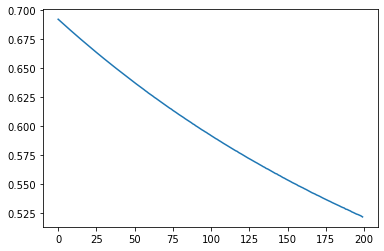

In [14]:
plt.plot(sgd_history.loss);

**Training with Adam**

In [15]:
model = LinearClassificationModel()

optmizer = Adam(lr = ConstantLearningRate(0.00005))

adam_history = model.fit(X, y, optimizer = optmizer, loss_fn = SoftmaxLoss(), epochs = 200)

Current epoch: 	 0, 	 loss: 0.6906001971005317
Current epoch: 	 10, 	 loss: 0.647070165122368
Current epoch: 	 20, 	 loss: 0.6076174210848352
Current epoch: 	 30, 	 loss: 0.5716834197521771
Current epoch: 	 40, 	 loss: 0.5389728595487068
Current epoch: 	 50, 	 loss: 0.509002824188397
Current epoch: 	 60, 	 loss: 0.4817107141738489
Current epoch: 	 70, 	 loss: 0.456500941785999
Current epoch: 	 80, 	 loss: 0.433639847918873
Current epoch: 	 90, 	 loss: 0.41245462258992643
Current epoch: 	 100, 	 loss: 0.3933619694070514
Current epoch: 	 110, 	 loss: 0.3759558519438218
Current epoch: 	 120, 	 loss: 0.36010518024963756
Current epoch: 	 130, 	 loss: 0.34528779361095874
Current epoch: 	 140, 	 loss: 0.33149473335959545
Current epoch: 	 150, 	 loss: 0.31947981799200204
Current epoch: 	 160, 	 loss: 0.3084552579248936
Current epoch: 	 170, 	 loss: 0.29815995325228195
Current epoch: 	 180, 	 loss: 0.28922369571927053
Current epoch: 	 190, 	 loss: 0.28028345585958264


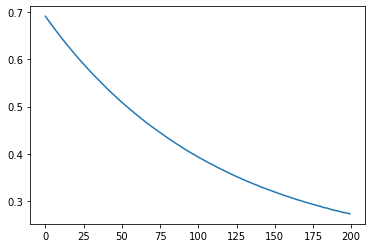

In [16]:
plt.plot(adam_history.loss);

Seems like Adam is doing better with this model on this training data

# Task 2

**Description**

Come up with a function of two variables of an arbitrary form and implement searcg for it's extremum using implemented optimizers

In [17]:
def rosenbrock(tensor: np.array) -> np.array:
    x, y = tensor
    return (y - x ** 2) ** 2 + (1 - x) ** 2

def rosenbrock_grad(tensor: np.array) -> np.array:
    x, y = tensor
    return np.array([
        (x ** 3) - x * y + 2 * x - 2,
        (y - x ** 2)
    ])

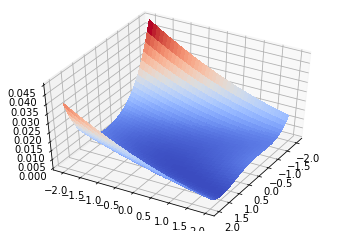

In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

ax.view_init(45, 30)

# Make data.
X = np.arange(-2, 2, 0.05)
Y = np.arange(-2, 2, 0.05)
X, Y = np.meshgrid(X, Y)
Z = ((1 - X) ** 2 + (Y - (X ** 2)) ** 2) * 0.001

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

plt.show()

In [19]:
class FunctionOptimizationTest:

    def __init__(self, initial, func, grad):
        self.initial = initial
        self.func = func
        self.grad = grad
    
    def test_optimizer(self, optimizer, epochs=50):
        x = self.initial.copy()
        
        history_x = []
        history_f = []
        for i in range(epochs):
            f = self.func(x)

            history_x.append(x.copy())
            history_f.append(f)

            update = optimizer.step(x, gradient=self.grad(x))
            x -= update

        return history_f, history_x

In [20]:
rosenbrock_test = FunctionOptimizationTest(
    initial=np.array([2.5, 2.5]),
    func=rosenbrock,
    grad=rosenbrock_grad
)

**Plot of norm of vector to function value**

In [21]:
def plot_x_difference(history):
    _, x = history
    x_diff = np.linalg.norm(np.diff(x, axis=0), axis=1)
    
    plt.plot(x_diff)

**Plot of path in contour**

In [22]:
def plot_path(history):
    _, path = history
    path = np.array(list(path))
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = ((1 - X) ** 2 + (Y - (X ** 2)) ** 2)
    
    plt.figure()
    plt.contour(X, Y, Z, np.arange(10) ** 5)
    plt.plot(path[:, 0], path[:, 1], '-o')

**Test SGD optimizer**

In [23]:
history_sgd = rosenbrock_test.test_optimizer(optimizer=SGD(lr=ConstantLearningRate(0.1)))

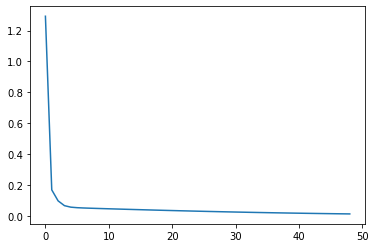

In [24]:
plot_x_difference(history_sgd);

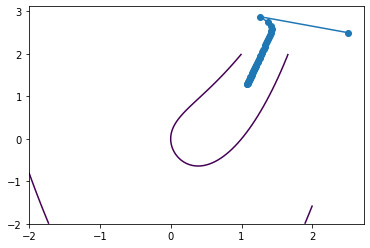

In [25]:
plot_path(history_sgd);

SGD works!

**Test Adam optimizer**

In [26]:
history_adam = rosenbrock_test.test_optimizer(optimizer=Adam(lr=ConstantLearningRate(0.1)))